# sandbox

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sc
import plotly.express as px

## SVD for linking cells

In [21]:
X1 = pd.DataFrame(
    data=[
        [1, 2, 0],
        [0, 1, 1],
        [0, 0, 1],
    ],
    index = ['C0', 'C1', 'C2'],
    columns = ['G0', 'G1', 'G2']
)
X1

,G0,G1,G2
C0,1,2,0
C1,0,1,1
C2,0,0,1


In [27]:
X1.T

,C0,C1,C2
G0,1,0,0
G1,2,1,0
G2,0,1,1


In [23]:
px.scatter_3d(X1, x='G0', y='G1', z='G2', width=500, height=500)

In [28]:
X1_cov = X1.dot(X1.T)
X1_cov

,C0,C1,C2
C0,5,2,0
C1,2,2,1
C2,0,1,1


In [52]:
from sklearn.utils.extmath import randomized_svd

In [55]:
U, Sigma, VT = randomized_svd(X1_cov.to_numpy(),
                              n_components=2,
                              random_state=42)

In [56]:
U

array([[ 0.88334449, -0.38693684],
       [ 0.45976517,  0.60545192],
       [ 0.09120579,  0.69549109]])

In [57]:
VT

array([[ 0.88334449,  0.45976517,  0.09120579],
       [-0.38693684,  0.60545192,  0.69549109]])

In [58]:
Sigma

array([6.04096459, 1.87053872])

In [59]:
svd.components_

array([[ 0.88334449,  0.45976517,  0.09120579],
       [-0.38693684,  0.60545192,  0.69549109]])

In [43]:
svd.singular_values_

array([6.04096459, 1.87053872])

In [29]:
U, s, Vh = sc.linalg.svd(X1_cov)

In [32]:
U_df = pd.DataFrame(U)

In [33]:
U_df

,0,1,2
0,-0.883344,0.386937,0.264542
1,-0.459765,-0.605452,-0.649649
2,-0.091206,-0.695491,0.712723


In [90]:
X2 = X1 * 2 + 1
X2.loc['C3'] = [1, 0, 0]
X2.index = ['C10', 'C11', 'C12', 'C13']
X2

,G0,G1,G2
C10,3,5,1
C11,1,3,3
C12,1,1,3
C13,1,0,0


In [91]:
X_concat = pd.concat([X1, X2])
X_concat.loc[X1.index, 'batch'] = 'X1'
X_concat.loc[X2.index, 'batch'] = 'X2'
X_concat

,G0,G1,G2,batch
C0,1,2,0,X1
C1,0,1,1,X1
C2,0,0,1,X1
C10,3,5,1,X2
C11,1,3,3,X2
C12,1,1,3,X2
C13,1,0,0,X2


In [92]:
px.scatter_3d(X_concat, x='G0', y='G1', z='G2', width=500, height=500, color='batch')

In [93]:
X_12 = X1.dot(X2.T)

In [94]:
X_12

,C10,C11,C12,C13
C0,13,7,3,1
C1,6,6,4,0
C2,1,3,3,0


In [95]:
U_12, Sigma_12, VT_12 = randomized_svd(X_12.to_numpy(),
                              n_components=2,
                              random_state=42)

In [96]:
U_12

array([[ 0.83983741, -0.47707591],
       [ 0.51123433,  0.53471316],
       [ 0.18251735,  0.69748148]])

In [97]:
VT_12

array([[ 0.79486968,  0.53264052,  0.28680333,  0.04711817],
       [-0.55387998,  0.47306532,  0.67541355, -0.11507698]])

In [99]:
Sigma_12

array([17.82406616,  4.14571098])

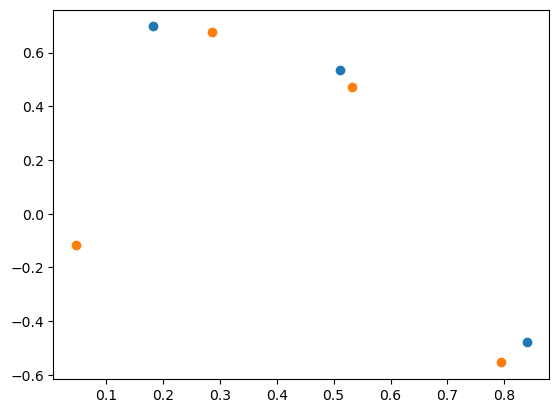

In [98]:
plt.scatter(x=U_12[:, 0], y=U_12[:, 1], label='X1')
plt.scatter(x=VT_12.T[:, 0], y=VT_12.T[:, 1], label='X2')

Assuming the link between related points of two different batches are linearly related?

In [100]:
U_12[0] 

array([ 0.83983741, -0.47707591])

In [101]:
VT_12.T[0]

array([ 0.79486968, -0.55387998])

In [102]:
np.dot(U_12[0], VT_12.T[0])

0.9318040829797302

In [117]:
X1

,G0,G1,G2
C0,1,2,0
C1,0,1,1
C2,0,0,1


In [124]:
loss_df = {}
for i, di in enumerate(U_12):
    for j, dj in enumerate(VT_12.T):
        loss_df[(X1.index[i], X2.index[j])] = np.dot(U_12[i], VT_12.T[j])

loss_df = pd.DataFrame(index=loss_df.keys(), data=loss_df.values(), columns=['dot_product'])
loss_df.index.names = ['X1', 'X2']

In [126]:
loss_df['exp(dot_product)'] = np.exp(loss_df['dot_product'])

In [133]:
for (x1, x2), df in loss_df.iterrows():
    x1_df = loss_df.loc[x1]
    x1_df = x1_df[x1_df.index != x2] # all except x2
    loss_df.loc[(x1, x2), 'denom'] = x1_df['exp(dot_product)'].sum()
    

In [149]:
loss_df['loss'] = loss_df['exp(dot_product)'] / loss_df['denom']

In [150]:
loss_df

dot_product  exp(dot_product)     denom      loss
X1 X2                                                    
C0 C10     0.931804          2.539086  3.269071  0.776700
   C11     0.221643          1.248126  4.560030  0.273710
   C12    -0.081355          0.921866  4.886290  0.188664
   C13     0.094472          1.099078  4.709078  0.233396
C1 C10     0.110198          1.116499  4.315735  0.258704
   C11     0.525258          1.690896  3.741339  0.451949
   C12     0.507776          1.661592  3.770642  0.440666
   C13    -0.037445          0.963248  4.468987  0.215541
C2 C10    -0.241244          0.785650  4.151573  0.189242
   C11     0.427170          1.532914  3.404309  0.450286
   C12     0.523435          1.687815  3.249408  0.519422
   C13    -0.071664          0.930843  4.006380  0.232340

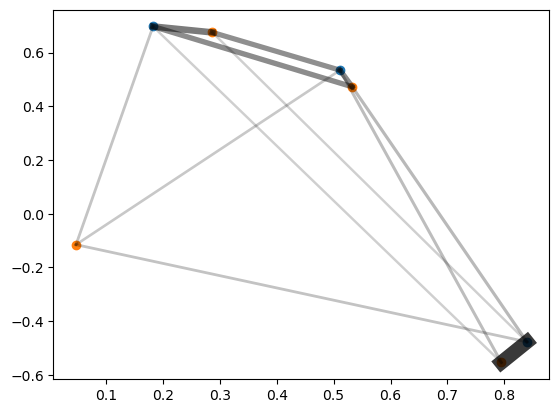

In [160]:
for (x1, x2), r in loss_df.iterrows():
    x1_idx = X1.index.tolist().index(x1)
    x2_idx = X2.index.tolist().index(x2)
    plt.plot(
        [U_12[x1_idx, 0], VT_12.T[x2_idx, 0]], 
        [U_12[x1_idx, 1], VT_12.T[x2_idx, 1]], 
        c='k', 
        linewidth=np.exp(r['loss'] * 3),
        alpha=r['loss']
    )
plt.scatter(x=U_12[:, 0], y=U_12[:, 1], label='X1')
plt.scatter(x=VT_12.T[:, 0], y=VT_12.T[:, 1], label='X2')

In [165]:
df = pd.DataFrame(index=pd.MultiIndex.from_product([np.arange(8),np.arange(8)]))
df.index.names = ['x', 'y']

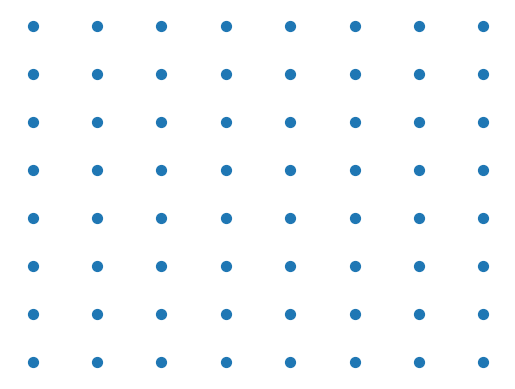

In [176]:
df.reset_index().plot.scatter(x='x', y='y', s=50)
plt.axis('off')
plt.show()

In [187]:
df['item'] = 'not pizza'
df.loc[
    [[0, 7], [0, 6], [1, 7], [1, 6], [1, 5], [2, 6]]
    ,'item'
] = 'pizza'

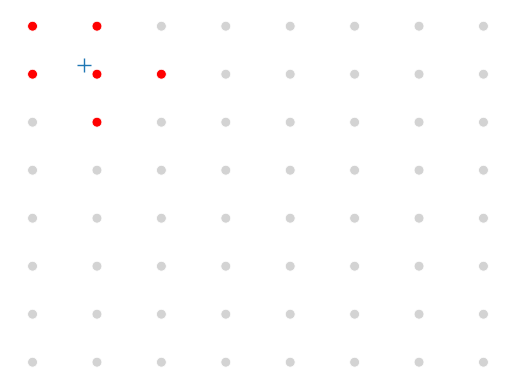

In [200]:
sns.scatterplot(df.reset_index(), x='x', y='y', hue='item', s=50, legend=False, palette={'pizza': 'red', 'not pizza': 'lightgray'})
plt.plot([0.8], [6.2], marker='+', markersize=10)
plt.axis('off')
plt.show()

# Multivariate normal

In [211]:
mean = np.zeros(3)
cov = [
    [1, 0.5, 0], [0.5, 1, 0], [0, 0, 1]
]
pts = np.random.multivariate_normal(mean, cov, size=800, check_valid='warn', tol=1e-8)

In [212]:
import plotly.express as px

In [213]:
fig = px.scatter_3d(x=pts[:, 0], y=pts[:, 1], z=pts[:, 2], width=500, height=500)
fig.update_traces(marker=dict(size=2))